In [1]:
from __future__ import annotations

import sys; sys.path.append('../utils')
import _confusion_matrix
from typing import Any

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import display as ipy_display

import torch
import transformers
from transformers import BertTokenizer
from transformers.trainer_utils import EvalPrediction

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
use_cuda = device == 'cuda'

print(f"Using device: {device}", end="\n\n")
print(f"Torch version: {torch.__version__}")

Using device: cuda

Torch version: 1.13.1+cu116


In [3]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

In [4]:
RAW_DATA_FILES = "../../data/reddit_ell_eng_raw_pos{}.csv"
RAW_DATA_MAXLEN = ['none',]

MARKERS = ['o', 's', 'v', 'p', 'x', 'd', 'h', '8', 'P', '*']
COLORS  = ['#404080', '#a52040', '#7d7dfa', '#d7d7d7', '#ff7f0e',
           '#2ca02c', '#1f77b4', '#9467bd', '#8c564b', '#e377c2']

all_results = pd.DataFrame()

In [5]:
maxlen = RAW_DATA_MAXLEN[0]

df = pd.read_csv(RAW_DATA_FILES.format(f"_{maxlen}" if maxlen != 'none' else ''),
                                        encoding='utf-8')

df, labels = encode_labels(df, 'label')

X = df['text']
y = df['label']

gss_1 = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss_1.split(X, y, groups=df['user_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

gss_2 = GroupShuffleSplit(n_splits=10, test_size=0.5, random_state=42)
val_idx, test_idx = next(gss_2.split(X_test, y_test, groups=df['user_id'].iloc[test_idx]))
X_val, X_test = X_test.iloc[val_idx], X_test.iloc[test_idx]
y_val, y_test = y_test.iloc[val_idx], y_test.iloc[test_idx]

print(f"{X_train.shape=}, {X_test.shape=}")
print(f"{y_train.shape=}, {y_test.shape=}")
print(f"{X_val.shape=}, {y_val.shape=}", end="\n\n")

X_train.shape=(7895,), X_test.shape=(1054,)
y_train.shape=(7895,), y_test.shape=(1054,)
X_val.shape=(975,), y_val.shape=(975,)



In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)


class RedditDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = RedditDataset(train_encodings, y_train.tolist())
test_dataset = RedditDataset(test_encodings, y_test.tolist())
val_dataset = RedditDataset(val_encodings, y_val.tolist())


def compute_metrics(eval_pred: EvalPrediction) -> dict[str, Any]:
    """Compute metrics for the model."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions, average='macro'),
        'recall': recall_score(labels, predictions, average='macro'),
        'f1': f1_score(labels, predictions, average='macro'),
    }

training_args = transformers.TrainingArguments(
    output_dir='../results/reports/',
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # batch size during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    logging_dir='./logs',
    overwrite_output_dir=True,
    evaluation_strategy='epoch',
)

trainer = transformers.Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()    
trainer.evaluate()

y_pred = trainer.predict(test_dataset).predictions.argmax(-1)
y_true = y_test.tolist()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/4940 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 975
  Batch size = 16


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 0.49027055501937866, 'eval_accuracy': 0.762051282051282, 'eval_precision': 0.7738323613668917, 'eval_recall': 0.7760565740955623, 'eval_f1': 0.7619949494949495, 'eval_runtime': 18.0221, 'eval_samples_per_second': 54.1, 'eval_steps_per_second': 3.385, 'epoch': 1.0}


Saving model checkpoint to ../results/reports/checkpoint-500
Configuration saved in ../results/reports/checkpoint-500\config.json


{'loss': 0.4368, 'learning_rate': 1.7975708502024295e-05, 'epoch': 1.01}


Model weights saved in ../results/reports/checkpoint-500\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 975
  Batch size = 16


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 0.5503785610198975, 'eval_accuracy': 0.7610256410256411, 'eval_precision': 0.771428632191437, 'eval_recall': 0.7742515664887444, 'eval_f1': 0.76092504406851, 'eval_runtime': 19.1903, 'eval_samples_per_second': 50.807, 'eval_steps_per_second': 3.179, 'epoch': 2.0}


Saving model checkpoint to ../results/reports/checkpoint-1000
Configuration saved in ../results/reports/checkpoint-1000\config.json


{'loss': 0.2821, 'learning_rate': 1.5951417004048585e-05, 'epoch': 2.02}


Model weights saved in ../results/reports/checkpoint-1000\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 975
  Batch size = 16


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 0.8775264620780945, 'eval_accuracy': 0.7651282051282051, 'eval_precision': 0.7707117088955163, 'eval_recall': 0.7754119285216987, 'eval_f1': 0.7647322251784726, 'eval_runtime': 18.1582, 'eval_samples_per_second': 53.695, 'eval_steps_per_second': 3.359, 'epoch': 3.0}


Saving model checkpoint to ../results/reports/checkpoint-1500
Configuration saved in ../results/reports/checkpoint-1500\config.json


{'loss': 0.1715, 'learning_rate': 1.3927125506072876e-05, 'epoch': 3.04}


Model weights saved in ../results/reports/checkpoint-1500\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 975
  Batch size = 16


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 1.1542497873306274, 'eval_accuracy': 0.7312820512820513, 'eval_precision': 0.7623368361109382, 'eval_recall': 0.7534166215414765, 'eval_f1': 0.7307583665691375, 'eval_runtime': 18.8328, 'eval_samples_per_second': 51.771, 'eval_steps_per_second': 3.239, 'epoch': 4.0}


Saving model checkpoint to ../results/reports/checkpoint-2000
Configuration saved in ../results/reports/checkpoint-2000\config.json


{'loss': 0.0956, 'learning_rate': 1.1902834008097166e-05, 'epoch': 4.05}


Model weights saved in ../results/reports/checkpoint-2000\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 975
  Batch size = 16


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 1.5414155721664429, 'eval_accuracy': 0.764102564102564, 'eval_precision': 0.7631852500273553, 'eval_recall': 0.7687591861994276, 'eval_f1': 0.7626220498446061, 'eval_runtime': 18.6189, 'eval_samples_per_second': 52.366, 'eval_steps_per_second': 3.276, 'epoch': 5.0}


Saving model checkpoint to ../results/reports/checkpoint-2500
Configuration saved in ../results/reports/checkpoint-2500\config.json


{'loss': 0.0406, 'learning_rate': 9.878542510121458e-06, 'epoch': 5.06}


Model weights saved in ../results/reports/checkpoint-2500\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 975
  Batch size = 16


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 1.8327585458755493, 'eval_accuracy': 0.7425641025641025, 'eval_precision': 0.7560427807486632, 'eval_recall': 0.7572135839715324, 'eval_f1': 0.7425467697496531, 'eval_runtime': 18.7615, 'eval_samples_per_second': 51.968, 'eval_steps_per_second': 3.251, 'epoch': 6.0}


Saving model checkpoint to ../results/reports/checkpoint-3000
Configuration saved in ../results/reports/checkpoint-3000\config.json


{'loss': 0.0197, 'learning_rate': 7.854251012145749e-06, 'epoch': 6.07}


Model weights saved in ../results/reports/checkpoint-3000\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 975
  Batch size = 16


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 2.045006275177002, 'eval_accuracy': 0.7282051282051282, 'eval_precision': 0.7554424528967609, 'eval_recall': 0.7489105489801707, 'eval_f1': 0.7278742117962778, 'eval_runtime': 18.0494, 'eval_samples_per_second': 54.018, 'eval_steps_per_second': 3.38, 'epoch': 7.0}


Saving model checkpoint to ../results/reports/checkpoint-3500
Configuration saved in ../results/reports/checkpoint-3500\config.json


{'loss': 0.0074, 'learning_rate': 5.8299595141700406e-06, 'epoch': 7.09}


Model weights saved in ../results/reports/checkpoint-3500\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 975
  Batch size = 16


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 1.967836618423462, 'eval_accuracy': 0.7517948717948718, 'eval_precision': 0.7634412727644772, 'eval_recall': 0.7655810835202805, 'eval_f1': 0.7517361111111112, 'eval_runtime': 17.967, 'eval_samples_per_second': 54.266, 'eval_steps_per_second': 3.395, 'epoch': 8.0}


Saving model checkpoint to ../results/reports/checkpoint-4000
Configuration saved in ../results/reports/checkpoint-4000\config.json


{'loss': 0.0073, 'learning_rate': 3.805668016194332e-06, 'epoch': 8.1}


Model weights saved in ../results/reports/checkpoint-4000\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 975
  Batch size = 16


  0%|          | 0/61 [00:00<?, ?it/s]

{'eval_loss': 2.0960452556610107, 'eval_accuracy': 0.7425641025641025, 'eval_precision': 0.7590469018932875, 'eval_recall': 0.7587285010701117, 'eval_f1': 0.7425630193315738, 'eval_runtime': 18.3061, 'eval_samples_per_second': 53.261, 'eval_steps_per_second': 3.332, 'epoch': 9.0}


Saving model checkpoint to ../results/reports/checkpoint-4500
Configuration saved in ../results/reports/checkpoint-4500\config.json


{'loss': 0.0041, 'learning_rate': 1.7813765182186236e-06, 'epoch': 9.11}


Model weights saved in ../results/reports/checkpoint-4500\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 975
  Batch size = 16


  0%|          | 0/61 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 975
  Batch size = 16


{'eval_loss': 2.124069929122925, 'eval_accuracy': 0.7425641025641025, 'eval_precision': 0.7596787674596952, 'eval_recall': 0.7590314844898275, 'eval_f1': 0.7425597695792907, 'eval_runtime': 19.1515, 'eval_samples_per_second': 50.91, 'eval_steps_per_second': 3.185, 'epoch': 10.0}
{'train_runtime': 4404.146, 'train_samples_per_second': 17.926, 'train_steps_per_second': 1.122, 'train_loss': 0.10797096648920886, 'epoch': 10.0}


  0%|          | 0/61 [00:00<?, ?it/s]

***** Running Prediction *****
  Num examples = 1054
  Batch size = 16


  0%|          | 0/66 [00:00<?, ?it/s]

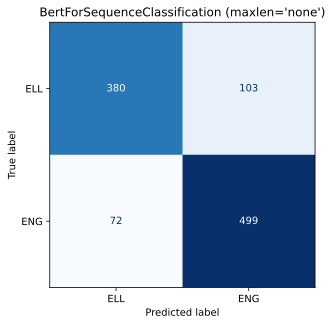

              precision    recall  f1-score   support

         ELL       0.84      0.79      0.81       483
         ENG       0.83      0.87      0.85       571

    accuracy                           0.83      1054
   macro avg       0.83      0.83      0.83      1054
weighted avg       0.83      0.83      0.83      1054



,precision,recall,f1-score,support,maxlen
ELL,0.840708,0.786749,0.812834,483.000000,none
ENG,0.828904,0.873905,0.850810,571.000000,none
accuracy,0.833966,0.833966,0.833966,0.833966,none
macro avg,0.834806,0.830327,0.831822,1054.000000,none
weighted avg,0.834313,0.833966,0.833407,1054.000000,none


In [7]:
cm = confusion_matrix(y_true, y_pred)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=labels).plot(colorbar=False, cmap='Blues')
plt.title(f"{model.__class__.__name__} ({maxlen=})")
plt.savefig(f'../results/{model.__class__.__name__}_{maxlen}.svg', format='svg')
plt.show();

report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
print(classification_report(y_true, y_pred, target_names=labels))

results = pd.DataFrame(report).transpose()
results['maxlen'] = maxlen
ipy_display(results)

all_results = pd.concat([all_results, results])

preds = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
preds.to_csv(f'../results/predictions/{model.__class__.__name__}_{maxlen}.csv', index=False, encoding='utf-8')